# Extract phases from solutions
Created 22/09/2024

Objectives:
* Extract the SPT phase from the states using solved boundary operators.

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../")

In [3]:
from itertools import chain, combinations
from collections import defaultdict
import re

In [4]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os
import pickle

In [5]:
import numpy as np
import jax.numpy as jnp

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

In [6]:
import quimb as qu
import quimb.tensor as qtn
from quimb.tensor.optimize import TNOptimizer

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


# Load data

In [7]:
DATA_DIR = r"../../../data/transverse_cluster_200_site_dmrg"

In [8]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [9]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [10]:
psi_dict = dict()

In [11]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

## Gate & circuit functions

In [12]:
def single_qubit_layer(circ, gate_round=None):
    """Apply a parametrizable layer of single qubit ``U3`` gates.
    """
    for i in range(circ.N):
        # initialize with random parameters
        params = qu.randn(3, dist='uniform')
        circ.apply_gate(
            'U3',
            *params,
            i,
            gate_round=gate_round,
            parametrize=True
        )

In [13]:
def two_qubit_layer(circ, gate2='CZ', start=0, gate_round=None):
    """Apply a layer of constant entangling gates.
    """
    num_sites = circ.N # Assuming this is even
    sites = [
        i % num_sites
        for i in range(start, start + num_sites)
    ]
    
    site_pairs = list(zip(sites[::2], sites[1::2]))

    for i, j in site_pairs:
        circ.apply_gate(
            gate2,
            i,
            j,
            gate_round=gate_round
        )

In [14]:
def ansatz_circuit(n, depth, first_site=0, gate2='CZ',
                   gate_tag=None, **kwargs):
    """Construct a circuit of single qubit and entangling layers.
    """
    circ = qtn.Circuit(n, **kwargs)

    for r in range(depth):
        # single qubit gate layer
        single_qubit_layer(circ, gate_round=r)

        # alternate between forward and backward CZ layers
        two_qubit_layer(
            circ, gate2=gate2, gate_round=r, start=r % 2)

    # add a final single qubit layer
    single_qubit_layer(circ, gate_round=r + 1)

    circ = circ.get_uni(transposed=True)

    if gate_tag is not None:
        for t in circ.tensors:
            t.add_tag(gate_tag)

    if first_site != 0:
        index_labels = ['k', 'b']

        index_map = {
            f'{l}{i}': f'{l}{i+first_site}'
            for i in range(n)
            for l in index_labels
        }

        circ.reindex(index_map, inplace=True)

    return circ

In [15]:
def ansatz_circuit_pair(leftmost_symmetry_site,
    num_symmetry_sites, num_boundary_sites, depth,
    gate2='CZ', **kwargs):
    """Construct a circuit of single qubit and entangling layers.
    """
    left_start_site = leftmost_symmetry_site-num_boundary_sites
    right_start_site = leftmost_symmetry_site+num_symmetry_sites

    left_circuit = ansatz_circuit(
        num_boundary_sites,
        depth,
        first_site=left_start_site,
        gate2=gate2,
        gate_tag='left',
        **kwargs
    )

    right_circuit = ansatz_circuit(
        num_boundary_sites,
        depth,
        first_site=right_start_site,
        gate2=gate2,
        gate_tag='right',
        **kwargs
    )

    circ_pair = left_circuit & right_circuit

    return circ_pair

In [16]:
def split_circ_pair(circ_pair):
    left_circuit = qtn.TensorNetwork(
        list(map(circ_pair.tensor_map.__getitem__, circ_pair.tag_map['left']))
    )

    right_circuit = qtn.TensorNetwork(
        list(map(circ_pair.tensor_map.__getitem__, circ_pair.tag_map['right']))
    )

    return (left_circuit, right_circuit)

## Load boundary operators

In [17]:
num_boundary_sites=2
left_most_symmetry_site=60
num_symmetry_sites=80

total_physical_dim = 2**num_boundary_sites

In [18]:
n=2
depth=2
gate2='CZ'

In [19]:
num_iterations=300

In [20]:
SOL_DIR = r"solutions/"

In [21]:
file_name_pattern = re.compile(r'^\d\.\d_\d\.pickle$')

In [22]:
def parse_file_name(file_name):
    if not bool(file_name_pattern.match(file_name)):
        return None

    file_name = '.'.join((file_name.split('.'))[:-1])

    b, sym_index = file_name.split('_')

    b = float(b)
    sym_index = int(sym_index)
    
    return (b, sym_index)

In [51]:
def generate_circuit_from_params(params, leftmost_symmetry_site,
    num_symmetry_sites, num_boundary_sites, depth):
    circ_pair = ansatz_circuit_pair(
        leftmost_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        depth
    )

    left_circuit, right_circuit = split_circ_pair(circ_pair)
    left_params, right_params = params

    left_circuit.set_params(left_params)
    right_circuit.set_params(right_params)

    """
    left_circuit = (
        qtn
        .tensor_arbgeom
        .TensorNetworkGenOperator(left_circuit)
    )
    left_circuit._sites = tuple(range(num_boundary_sites))
    left_circuit._site_tag_id = 'I{}'
    left_circuit._upper_ind_id = 'k{}'
    left_circuit._lower_ind_id = 'b{}'

    right_circuit = (
        qtn
        .tensor_arbgeom
        .TensorNetworkGenOperator(right_circuit)
    )
    right_circuit._sites = tuple(range(num_boundary_sites))
    right_circuit._site_tag_id = 'I{}'
    right_circuit._upper_ind_id = 'k{}'
    right_circuit._lower_ind_id = 'b{}'
    """

    return (left_circuit, right_circuit)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [52]:
boundary_operator_solutions = dict()
boundary_operator_scores = dict()

for local_file_name in list(os.walk(SOL_DIR))[0][2]:
    f_name = r"{}/{}".format(SOL_DIR, local_file_name, ignore_unknown=False)

    key = parse_file_name(local_file_name)

    if key is not None:
        with open(f_name, 'rb') as f:
            final_score, params = pickle.load(f)

            circ_pair = generate_circuit_from_params(
                params,
                left_most_symmetry_site,
                num_symmetry_sites,
                num_boundary_sites,
                depth
            )
            
            boundary_operator_scores[key] = final_score
            boundary_operator_solutions[key] = circ_pair

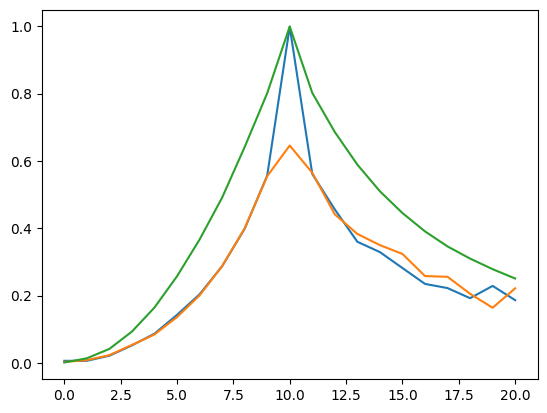

In [25]:
for k in range(1, 4):
    keys = sorted(list(i for i, j in boundary_operator_scores if j == k))
    l = [boundary_operator_scores[(b, k)] for b in keys]
    plt.plot(l)

# Definitions

In [26]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])

In [27]:
symmetry_actions = [
    [np_I, np_I],
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [28]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [29]:
def generate_problem_rdm(quimb_psi, symmetry_site_pairs, leftmost_symmetry_site,
                         num_symmetry_sites, num_boundary_sites):
    q_top = quimb_psi.copy(deep=True)
    for i, s in symmetry_site_pairs:
        q_top.gate(
            s,
            where=i,
            contract=False,
            inplace=True
        )

    
    indices_to_map = list(chain(
        range(leftmost_symmetry_site-num_boundary_sites, leftmost_symmetry_site),
        range(leftmost_symmetry_site+num_symmetry_sites, leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites)
    ))

    index_mapping = {f'k{i}': f'b{i}' for i in indices_to_map}

    q_bottom = (
        quimb_psi
        .copy()
        .reindex(index_mapping, inplace=True)
        .conj()
    )

    sites_to_contract = {
        'left': list(range(leftmost_symmetry_site-num_boundary_sites)),
        'middle': list(range(leftmost_symmetry_site, leftmost_symmetry_site+num_symmetry_sites)),
        'right': list(range(leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites, quimb_psi.L))
    }

    tags_to_contract = {
        k: [f'I{i}' for i in v]
        for k, v in sites_to_contract.items()
    }

    tn = (q_top & q_bottom)

    tnc = (
        tn
        .contract(tags_to_contract['left'])
        .contract(tags_to_contract['middle'])
        .contract(tags_to_contract['right'])
    )

    return tnc

In [30]:
def generate_rdm_from_tenpy_psi(mps_psi, symmetry_site_pairs,
    leftmost_symmetry_site, num_symmetry_sites, num_boundary_sites):
    
    psi_arrays = list()
    psi_arrays.append(mps_psi.get_B(0, 'Th')[0, ...].to_ndarray())
    for i in range(1, mps_psi.L-1):
        psi_arrays.append(mps_psi.get_B(i).to_ndarray())
    psi_arrays.append(mps_psi.get_B(mps_psi.L-1)[..., 0].to_ndarray())
    
    q1 = (
        qtn
        .tensor_1d
        .MatrixProductState(psi_arrays, shape='lpr')
    )
    
    problem_rdm = generate_problem_rdm(
        q1,
        symmetry_site_pairs,
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites
    )

    return problem_rdm

## SPT extraction functions

In [31]:
symmetry_combination_labels = list(combinations(symmetry_labels, 2))

In [32]:
symmetry_combination_labels

[('II', 'IX'),
 ('II', 'XI'),
 ('II', 'XX'),
 ('IX', 'XI'),
 ('IX', 'XX'),
 ('XI', 'XX')]

In [33]:
e, a, b, c = symmetry_labels

In [34]:
group_products = [
    (a, b, c),
    (b, a, c),
    (a, c, b),
    (c, a, b),
    (c, b, a),
    (b, c, a)
]

In [84]:
"""
Old function

def get_proj_rep_phase(rho, u_g, u_h, u_gh):
    full_circ = (
        u_g
        .gate_lower_with_op_lazy(u_h)
        .gate_lower_with_op_lazy(u_gh.H)
    )

    t = (rho & full_circ)

    out = t.trace()

    return (out/(np.abs(out)), np.abs(out))
"""

'\nOld function\n\ndef get_proj_rep_phase(rho, u_g, u_h, u_gh):\n    full_circ = (\n        u_g\n        .gate_lower_with_op_lazy(u_h)\n        .gate_lower_with_op_lazy(u_gh.H)\n    )\n\n    t = (rho & full_circ)\n\n    out = t.trace()\n\n    return (out/(np.abs(out)), np.abs(out))\n'

In [79]:
def relabel_index(index, old_label, new_label):
    index_tail = index[len(old_label):]
    return new_label + index_tail

In [83]:
def relabel_circuit(circuit_tn, new_k_label, new_b_label, old_k_label='k',
                   old_b_label='b'):
    k_regex = re.compile(rf"^{old_k_label}\d+$")
    b_regex = re.compile(rf"^{old_b_label}\d+$")

    old_k_indices = [
        k for k in circuit_tn.ind_map
        if bool(re.search(k_regex, k))
    ]
    
    old_b_indices = [
        k for k in circuit_tn.ind_map
        if bool(re.search(b_regex, k))
    ]
    
    k_out_indices = [
        relabel_index(i, old_k_label, new_k_label)
        for i in old_k_indices
    ]
        
    b_out_indices = [
        relabel_index(i, old_b_label, new_b_label)
        for i in old_b_indices
    ]

    mapping = dict(
        chain(
            zip(old_k_indices, k_out_indices),
            zip(old_b_indices, b_out_indices)
        )
    )

    circuit_tn.reindex(mapping, inplace=True)

In [170]:
def get_proj_rep_phase(rho, u_g, u_h, u_gh):
    us = [u_g.copy(), u_h.copy(), u_gh.copy()]

    relabel_circuit(us[0], 'k', 'l')
    relabel_circuit(us[1], 'l', 'm')
    relabel_circuit(us[2], 'b', 'm')

    us[2] = us[2].conj()

    out = (rho & us[0] & us[1] & us[2]) ^ ...

    return (out/(np.abs(out)), np.abs(out))

In [36]:
def get_quimb_mps_from_tenpy_mps(tenpy_mps):
    psi_arrays = list()
    psi_arrays.append(tenpy_mps.get_B(0, 'Th')[0, ...].to_ndarray())
    for i in range(1, tenpy_mps.L-1):
        psi_arrays.append(tenpy_mps.get_B(i).to_ndarray())
    psi_arrays.append(tenpy_mps.get_B(tenpy_mps.L-1)[..., 0].to_ndarray())
    
    quimb_mps = (
        qtn
        .tensor_1d
        .MatrixProductState(psi_arrays, shape='lpr')
    )

    return quimb_mps

In [114]:
def get_proj_rep_phases(tenpy_mps, unitaries):
    quimb_mps = get_quimb_mps_from_tenpy_mps(tenpy_mps)
    sites = [
        int(s[1:]) for s in unitaries[0].ind_map
        if s[0]=='k'
    ]
    rho = quimb_mps.partial_trace_to_mpo(sites, rescale_sites=False)
    out = list()

    unitaries_dict = {
        k: v for k, v in zip(symmetry_labels[1:], unitaries)
    }

    out_phases = list()
    for a, b, c in group_products:
        phase = get_proj_rep_phase(
            rho,
            unitaries_dict[a],
            unitaries_dict[b],
            unitaries_dict[c]
        )

        out_phases.append(phase)

    return out_phases

# Extract phases

In [86]:
b_params = np.delete(np.round(np.linspace(0, 2, 21), 3), 10)

In [171]:
proj_rep_phases = list()

for t in b_params:
    tenpy_mps = psi_dict[t]

    unitaries = [boundary_operator_solutions[(t, i)] for i in [1,2,3]]

    left_unitaries, right_unitaries = zip(*unitaries)

    left_phases = get_proj_rep_phases(tenpy_mps, left_unitaries)
    right_phases = get_proj_rep_phases(tenpy_mps, right_unitaries)

    proj_rep_phases.append([left_phases, right_phases])

In [172]:
proj_rep_phases = np.array(proj_rep_phases)

In [173]:
np.round(
    proj_rep_phases[..., ::2, 0]/proj_rep_phases[..., 1::2, 0],
    2
)

array([[[-1.  -0.j  , -1.  -0.j  , -1.  -0.j  ],
        [-1.  +0.j  , -1.  -0.j  , -1.  +0.j  ]],

       [[-1.  -0.j  , -1.  +0.j  , -1.  -0.01j],
        [-1.  +0.j  , -1.  -0.j  , -1.  -0.j  ]],

       [[-1.  -0.j  , -1.  -0.j  , -1.  +0.j  ],
        [-1.  -0.01j, -1.  -0.01j, -1.  -0.01j]],

       [[-1.  +0.j  , -1.  +0.01j, -1.  -0.02j],
        [-1.  +0.01j, -1.  +0.02j, -1.  +0.01j]],

       [[-1.  +0.j  , -1.  -0.02j, -1.  -0.01j],
        [-1.  +0.j  , -1.  +0.03j, -1.  +0.01j]],

       [[-1.  +0.j  , -1.  +0.02j, -1.  -0.j  ],
        [-1.  +0.j  , -1.  +0.02j, -1.  +0.02j]],

       [[-1.  -0.03j, -1.  -0.05j, -1.  -0.j  ],
        [-1.  +0.01j, -1.  +0.03j, -1.  +0.01j]],

       [[-1.  +0.02j, -1.  +0.01j, -1.  -0.01j],
        [-1.  +0.j  , -1.  +0.j  , -1.  -0.01j]],

       [[-1.  +0.03j, -1.  -0.01j, -1.  +0.03j],
        [-1.  +0.01j, -1.  +0.06j, -1.  +0.03j]],

       [[-1.  -0.j  , -1.  -0.03j, -1.  -0.j  ],
        [-1.  -0.04j, -1.  +0.05j, -1.  -0.07j]],



In [174]:
gauge_invariant_proj_rep_phase = proj_rep_phases[..., ::2, 0]/proj_rep_phases[..., 1::2, 0]

In [175]:
np.round(gauge_invariant_proj_rep_phase, 2)

array([[[-1.  -0.j  , -1.  -0.j  , -1.  -0.j  ],
        [-1.  +0.j  , -1.  -0.j  , -1.  +0.j  ]],

       [[-1.  -0.j  , -1.  +0.j  , -1.  -0.01j],
        [-1.  +0.j  , -1.  -0.j  , -1.  -0.j  ]],

       [[-1.  -0.j  , -1.  -0.j  , -1.  +0.j  ],
        [-1.  -0.01j, -1.  -0.01j, -1.  -0.01j]],

       [[-1.  +0.j  , -1.  +0.01j, -1.  -0.02j],
        [-1.  +0.01j, -1.  +0.02j, -1.  +0.01j]],

       [[-1.  +0.j  , -1.  -0.02j, -1.  -0.01j],
        [-1.  +0.j  , -1.  +0.03j, -1.  +0.01j]],

       [[-1.  +0.j  , -1.  +0.02j, -1.  -0.j  ],
        [-1.  +0.j  , -1.  +0.02j, -1.  +0.02j]],

       [[-1.  -0.03j, -1.  -0.05j, -1.  -0.j  ],
        [-1.  +0.01j, -1.  +0.03j, -1.  +0.01j]],

       [[-1.  +0.02j, -1.  +0.01j, -1.  -0.01j],
        [-1.  +0.j  , -1.  +0.j  , -1.  -0.01j]],

       [[-1.  +0.03j, -1.  -0.01j, -1.  +0.03j],
        [-1.  +0.01j, -1.  +0.06j, -1.  +0.03j]],

       [[-1.  -0.j  , -1.  -0.03j, -1.  -0.j  ],
        [-1.  -0.04j, -1.  +0.05j, -1.  -0.07j]],



In [176]:
gauge_invariant_proj_rep_angle = np.imag(np.log(gauge_invariant_proj_rep_phase))
gauge_invariant_proj_rep_angle[gauge_invariant_proj_rep_angle<=-np.pi/2] += 2*np.pi

In [177]:
markers = ['<', '>']

In [178]:
colors = [
    'tab:blue',
    'tab:orange',
    'tab:green'
]   

In [179]:
e, a, b, c = symmetry_labels

In [180]:
symmetry_pair_labels = [
    a + ',' + b,
    a + ',' + c,
    c + ',' + b
]

In [181]:
side_labels = ['Left', 'Right']

In [182]:
gauge_invariant_proj_rep_angle.shape

(20, 2, 3)

In [184]:
mean_gauge_invariant_proj_rep_angle = np.mean(gauge_invariant_proj_rep_angle, axis=(1,2))
max_gauge_invariant_proj_rep_angle = np.max(gauge_invariant_proj_rep_angle, axis=(1,2))
min_gauge_invariant_proj_rep_angle = np.min(gauge_invariant_proj_rep_angle, axis=(1,2))

min_max_gauge_invariant_proj_rep_angle = np.stack(
    [
        min_gauge_invariant_proj_rep_angle,
        max_gauge_invariant_proj_rep_angle
    ],
    axis=0
)

error_gauge_invariant_proj_rep_angle = (
    min_max_gauge_invariant_proj_rep_angle
    - mean_gauge_invariant_proj_rep_angle[np.newaxis, :]
)
error_gauge_invariant_proj_rep_angle = np.abs(error_gauge_invariant_proj_rep_angle)

In [185]:
np.max(error_gauge_invariant_proj_rep_angle)

0.10836096541397097

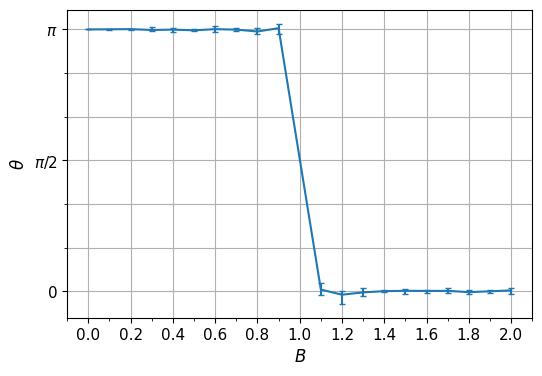

In [186]:
fig, ax = plt.subplots(figsize=(6,4))

plt.errorbar(
    b_params,
    mean_gauge_invariant_proj_rep_angle,
    yerr=error_gauge_invariant_proj_rep_angle,
    color='tab:blue',
    fmt='-',
    capsize=2
)

ax.xaxis.set_major_locator(
    matplotlib.ticker.MultipleLocator(0.2)
)
ax.xaxis.set_minor_locator(
    matplotlib.ticker.MultipleLocator(0.1)
)

ax.set_yticks(
    np.linspace(0, np.pi, 3),
    labels=['$0$', '$\pi/2$', '$\pi$']
)

ax.set_yticks(
    [np.pi/6, np.pi/3, 2*np.pi/3, 5*np.pi/6],
    minor=True
)

ax.tick_params(
    axis='both',
    which='major',
    labelsize=11
)

ax.grid(
    axis='y',
    which='both'
)
ax.grid(
    axis='x',
    which='major'
)

ax.set_ylabel(r'$\theta$', fontsize=12)
ax.set_xlabel('$B$', fontsize=12)

fig.savefig(r'plots/proj_rep_angle_from_circ_bosonic.png', dpi=200)

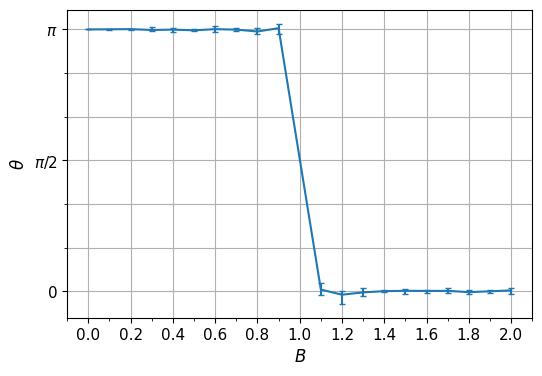

In [186]:
fig, ax = plt.subplots(figsize=(6,4))

plt.errorbar(
    b_params,
    mean_gauge_invariant_proj_rep_angle,
    yerr=error_gauge_invariant_proj_rep_angle,
    color='tab:blue',
    fmt='-',
    capsize=2
)

ax.xaxis.set_major_locator(
    matplotlib.ticker.MultipleLocator(0.2)
)
ax.xaxis.set_minor_locator(
    matplotlib.ticker.MultipleLocator(0.1)
)

ax.set_yticks(
    np.linspace(0, np.pi, 3),
    labels=['$0$', '$\pi/2$', '$\pi$']
)

ax.set_yticks(
    [np.pi/6, np.pi/3, 2*np.pi/3, 5*np.pi/6],
    minor=True
)

ax.tick_params(
    axis='both',
    which='major',
    labelsize=11
)

ax.grid(
    axis='y',
    which='both'
)
ax.grid(
    axis='x',
    which='major'
)

ax.set_ylabel(r'$\theta$', fontsize=12)
ax.set_xlabel('$B$', fontsize=12)

fig.savefig(r'plots/proj_rep_angle_from_circ_bosonic.png', dpi=200)

In [187]:
gauge_invariant_proj_rep_real_phase = np.real(gauge_invariant_proj_rep_phase)
mean_gauge_invariant_proj_rep_real_phase = np.mean(gauge_invariant_proj_rep_real_phase, axis=(1,2))
max_gauge_invariant_proj_rep_real_phase = np.max(gauge_invariant_proj_rep_real_phase, axis=(1,2))
min_gauge_invariant_proj_rep_real_phase = np.min(gauge_invariant_proj_rep_real_phase, axis=(1,2))

min_max_gauge_invariant_proj_rep_real_phase = np.stack(
    [
        min_gauge_invariant_proj_rep_real_phase,
        max_gauge_invariant_proj_rep_real_phase
    ],
    axis=0
)

error_gauge_invariant_proj_rep_real_phase = (
    min_max_gauge_invariant_proj_rep_real_phase
    - mean_gauge_invariant_proj_rep_real_phase[np.newaxis, :]
)
error_gauge_invariant_proj_rep_real_phase = np.abs(error_gauge_invariant_proj_rep_real_phase)

In [189]:
np.max(error_gauge_invariant_proj_rep_real_phase)

0.008796700516767397

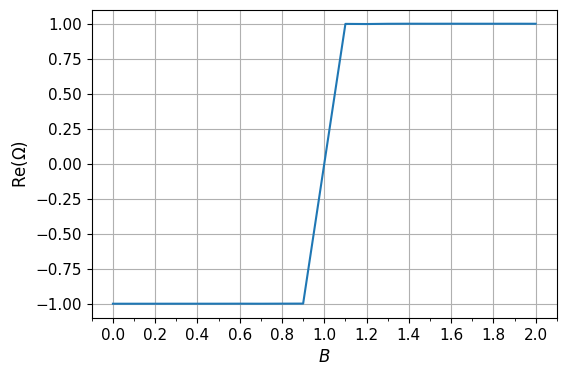

In [195]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(
    b_params,
    mean_gauge_invariant_proj_rep_real_phase,
    color='tab:blue'
)

ax.xaxis.set_major_locator(
    matplotlib.ticker.MultipleLocator(0.2)
)
ax.xaxis.set_minor_locator(
    matplotlib.ticker.MultipleLocator(0.1)
)

"""
ax.set_yticks(
    np.linspace(0, np.pi, 3),
    labels=['$0$', '$\pi/2$', '$\pi$']
)

ax.set_yticks(
    [np.pi/6, np.pi/3, 2*np.pi/3, 5*np.pi/6],
    minor=True
)
"""

ax.tick_params(
    axis='both',
    which='major',
    labelsize=11
)

ax.grid(
    axis='y',
    which='both'
)
ax.grid(
    axis='x',
    which='major'
)

ax.set_ylabel(r'Re$(\Omega)$', fontsize=12)
ax.set_xlabel('$B$', fontsize=12)

fig.savefig(r'plots/proj_rep_real_phase_from_circ_bosonic.png', dpi=200)

# Scores

In [196]:
scores = list()
for t in b_params:

    scores.append([boundary_operator_scores[(t, i)] for i in [1,2,3]])

scores = np.array(scores)

In [199]:
overlaps = np.sqrt(1-scores)

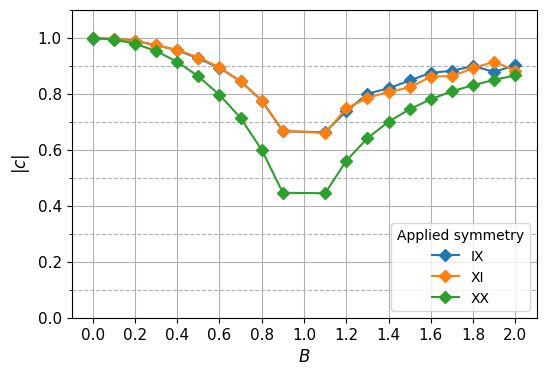

In [206]:
fig, ax = plt.subplots(figsize=(6,4))

for j, (col, label) in enumerate(zip(colors, symmetry_labels[1:])):
    plt.plot(
        b_params,
        overlaps[:, j],
        color=col,
        label = label,
        marker='D'
    )

ax.xaxis.set_major_locator(
    matplotlib.ticker.MultipleLocator(0.2)
)

ax.yaxis.set_minor_locator(
    matplotlib.ticker.MultipleLocator(0.1)
)

#ax.set_yscale('log')
ax.set_ylim(bottom=0, top=1.1)
ax.tick_params(
    axis='both',
    which='major',
    labelsize=11
)

ax.grid()
ax.grid(
    which='minor',
    axis='y',
    linestyle='--',
    zorder=-1e10
)
ax.set_axisbelow(True)

ax.set_ylabel(r'$\vert c \vert$', fontsize=12)
ax.set_xlabel('$B$', fontsize=12)

ax.legend(loc='lower right', title='Applied symmetry')

#fig.suptitle(r'Final cost $L$ with symmetry $g$ as a function of $B$')

fig.savefig(r'plots/overlaps_from_circ_bosonic.png', dpi=200)

# Conclusions

It works!